# LOAD training data 

In [2]:
import pandas as pd

# Read the CSV
df = pd.read_csv(r"D:\Aviation\IMSR\final_df_resource_summary_AND_gacc_activity_AND_national_activity_2015_2021_WITH_water_lines_cooridors.csv")

# Print column names
#print(df.columns.tolist())

df = df[
    (df['RPL_THEMES'] != -999) &
    (df['EPL_MUNIT'] != -999)
]

mapping = {'LIGHT': 0, 'MODERATE': 1, 'HEAVY': 2}
df['initial_attack_activity'] = df['initial_attack_activity'].map(mapping)



matched = df

import numpy as np
# Define variable sets
hazard_vars = [
    'vpd_Normal', 'bi_Normal', 'fm100_Normal',
    'srad_Normal', 'sph_Normal', 'Slope', 'TRI', 'TPI', 'Elevation',
    'erc', 'vs', 'Aridity_index', 'SDI'
]

values_vars = [
    'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m'
]

capacity_vars = [
    'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
    'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
]

predictors = hazard_vars + values_vars + capacity_vars


# # Define placeholder values and problematic columns
# placeholder_vals = [-999, -999.0, -3.402823e+38]
# problem_columns = ['SDI', 'GHM', 'RPL_THEMES', 'EPL_MUNIT']

# # Print length before cleaning
# print(f"Original matched length: {len(matched)}")

# # Replace known placeholder values with NaN
# for col in problem_columns:
#     matched[col] = matched[col].replace(placeholder_vals, np.nan)

print(len(matched))

# Drop rows where SDI or GHM are < 0
#matched = matched[(matched['SDI'] > 0) & (matched['GHM'] > 0)]

matched['SDI'] = matched['SDI'].where(matched['SDI'] >= 0, 0)
matched['GHM'] = matched['GHM'].where(matched['GHM'] >= 0, 0)

# Drop rows with missing predictor or target values
matched_clean = matched.dropna(subset=predictors + ['event_type'])

# Print length after cleaning
print(f"Cleaned matched_clean length: {len(matched_clean)}")

# Print unique event_type values and their counts
event_counts = matched_clean['event_type'].value_counts()
print("Event type counts:")
print(event_counts)

# Print number of unique event types
print(f"\nNumber of unique event types: {matched_clean['event_type'].nunique()}")


C:\Users\magst\AppData\Local\Temp\ipykernel_2788\2094404481.py:4: DtypeWarning: Columns (14,15,16,17,311) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"D:\Aviation\IMSR\final_df_resource_summary_AND_gacc_activity_AND_national_activity_2015_2021_WITH_water_lines_cooridors.csv")


455960
Cleaned matched_clean length: 445107
Event type counts:
event_type
0    435433
1      9674
Name: count, dtype: int64

Number of unique event types: 2


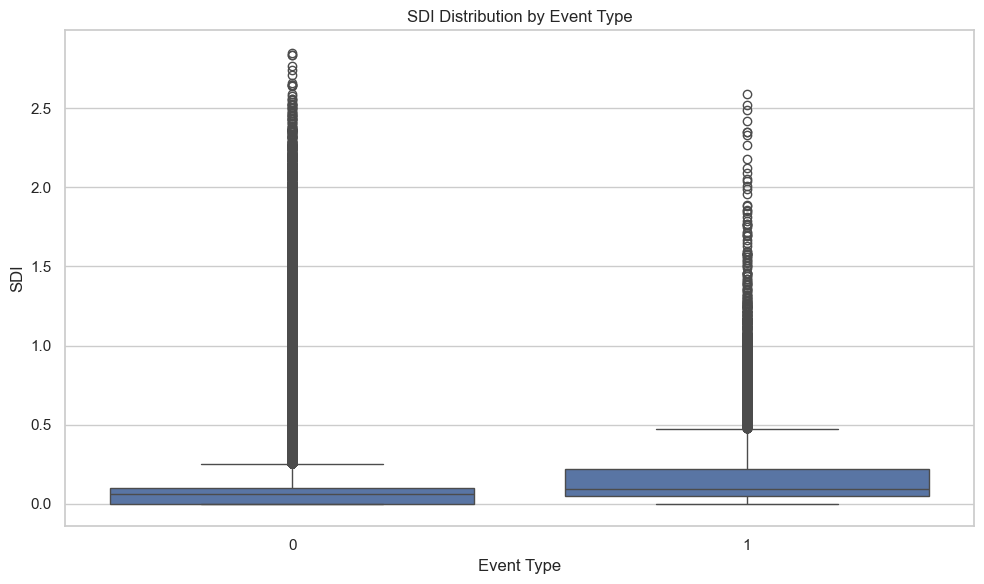

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=matched_clean, x='event_type', y='SDI')

# Set titles and labels
plt.title('SDI Distribution by Event Type')
plt.xlabel('Event Type')
plt.ylabel('SDI')

# Show the plot
plt.tight_layout()
plt.show()


In [6]:
corr = X.corr()
print(corr['SDI'].sort_values(ascending=False))

SDI                        1.000000
TRI                        0.761699
Slope                      0.754995
Elevation                  0.342048
dist_to_transline_m        0.319456
dist_to_water_m            0.308368
NPL                        0.154414
type_2_teams               0.146122
helicopters                0.142437
crews                      0.129365
GACC_PL                    0.122066
type_1_teams               0.115035
srad_Normal                0.102982
nimos                      0.091897
TPI                        0.089331
erc                        0.079819
bi_Normal                  0.071015
initial_attack_activity    0.068882
engines                    0.064745
Aridity_index              0.055392
vpd_Normal                 0.026900
new_large_fires           -0.027733
RPL_THEMES                -0.042126
sph_Normal                -0.060574
vs                        -0.061654
EPL_MUNIT                 -0.113982
Popo_1km                  -0.129064
fm100_Normal              -0

# Feature Selection

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- Separate by class ---
df_0 = matched_clean[matched_clean['event_type'] == 0]
df_1 = matched_clean[matched_clean['event_type'] == 1]

# --- Sample desired number from each class ---
df_0_sample = df_0.sample(n=435433, random_state=42)
df_1_sample = df_1.sample(n=9674, random_state=42)

# --- Combine and shuffle ---
subset = pd.concat([df_0_sample, df_1_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# --- Assign to working DataFrame ---
matched_clean2 = subset

# --- Define Features (X) and Target (y) ---
X = matched_clean2[predictors]
y = matched_clean2['event_type']

# --- Encode Target Variable ---
le = LabelEncoder()
y = le.fit_transform(y)
print(f"\nOriginal 'event_type' classes: {le.classes_}")

# # --- Define Pipeline ---
# pipe = Pipeline([
#     ('scale', StandardScaler()),
#     ('lasso', SelectFromModel(
#         LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced'))),
#     ('logit', LogisticRegression(penalty=None, solver='lbfgs', class_weight='balanced'))
# ])

# # --- Grid Search for Best C ---
# param_grid = {
#     'lasso__estimator__C': np.logspace(-3, 1, 20)  # from 0.001 to 10
# }

from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('logit', LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, class_weight='balanced'))
])
param_grid = {
    'logit__C': np.logspace(-3, 0.1, 20),
    'logit__l1_ratio': [0.1, 0.5, 0.9]  # Tune mixing between L1 and L2
}

cv = StratifiedKFold(5, shuffle=True, random_state=42)

gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    error_score='raise'
).fit(X, y)

# Save full CV results for plotting/inspection
cv_df = pd.DataFrame(gs.cv_results_)
cv_df.to_csv("D:\\Aviation\\Outputs\\cv_results_lasso_grid_elasticnet_2.csv", index=False)


# # --- Extract Results ---
# best_C = gs.best_params_['lasso__estimator__C']
# best_score = gs.best_score_
# keep_mask = gs.best_estimator_.named_steps['lasso'].get_support()
# final_feats = X.columns[keep_mask]

# print(f"Best C: {best_C}")
# print(f"Mean PR-AUC (CV): {best_score:.3f}")
# print("Selected features:", final_feats.tolist())



# # --- Extract coefficients from final model ---
# coef = gs.best_estimator_.named_steps['logit'].coef_[0]
# #selected_coefs = gs.best_estimator_.named_steps['logit'].coef_[0]
# selected_coefs = coef#[keep_mask]

# # --- Save to CSV ---
# output_df = pd.DataFrame({
#     'feature': final_feats,
#     'coefficient': selected_coefs
# })
# output_df['abs_coef'] = output_df['coefficient'].abs()
# output_df = output_df.sort_values(by='abs_coef', ascending=False)

# # Save coefficients and features
# output_df.to_csv(r"D:\\Aviation\\Outputs\\selected_features_with_coefficients.csv", index=False)

# # Save summary metadata
# summary = pd.DataFrame({
#     'best_C': [best_C],
#     'mean_pr_auc_cv': [best_score],
#     'n_selected_features': [len(final_feats)]
# })
# summary.to_csv(r"D:\\Aviation\\Outputs\\lasso_feature_selection_summary.csv", index=False)

# print("Saved selected features and summary to CSV.")

# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np


best_C = gs.best_params_['logit__C']
best_l1_ratio = gs.best_params_['logit__l1_ratio']
best_score = gs.best_score_

print(f"Best C: {best_C}")
print(f"Best l1_ratio: {best_l1_ratio}")
print(f"Mean PR-AUC (CV): {best_score:.3f}")

# Extract all coefficients and associated features
coef = gs.best_estimator_.named_steps['logit'].coef_[0]
final_feats = X.columns

# Save to CSV
output_df = pd.DataFrame({
    'feature': final_feats,
    'coefficient': coef
})
output_df['abs_coef'] = output_df['coefficient'].abs()
output_df = output_df.sort_values(by='abs_coef', ascending=False)
output_df.to_csv(r"D:\\Aviation\\Outputs\\selected_features_with_coefficients_elasticnet_2.csv", index=False)

# Save summary
summary = pd.DataFrame({
    'best_C': [best_C],
    'best_l1_ratio': [best_l1_ratio],
    'mean_pr_auc_cv': [best_score],
    'n_selected_features': [len(final_feats)]
})
summary.to_csv(r"D:\\Aviation\\Outputs\\lasso_feature_selection_summary_elasticnet_2.csv", index=False)


# # --- CV performance plot ----------------------------------------------------
# C_vals = gs.cv_results_['param_lasso__estimator__C'].data.astype(float)
# mean_scores = gs.cv_results_['mean_test_score']
# std_scores = gs.cv_results_['std_test_score']

# plt.figure(figsize=(6, 4))
# plt.errorbar(C_vals, mean_scores, yerr=std_scores, marker='o', linestyle='-')
# plt.xscale('log')
# plt.xlabel('Regularization strength (C, log scale)')
# plt.ylabel('Mean PR-AUC (5-fold CV)')
# plt.title('Grid-Search Performance')
# plt.tight_layout()
# plt.savefig(r'D:\Aviation\Outputs\gridsearch_pr_auc.png', dpi=300)
# plt.close()

# --- Coefficient bar plot ---------------------------------------------------
coef_df = pd.read_csv(r'D:\Aviation\Outputs\selected_features_with_coefficients_elasticnet_2.csv')
coef_df = coef_df.sort_values('abs_coef')  # smallest at top for barh

plt.figure(figsize=(8, max(2, 0.3 * len(coef_df))))
plt.barh(coef_df['feature'], coef_df['coefficient'])
plt.xlabel('Coefficient')
plt.title('Selected Feature Coefficients')
plt.tight_layout()
plt.savefig(r'D:\Aviation\Outputs\selected_feature_coefficients_elasticnet_2.png', dpi=300)
plt.close()


# # --- CV performance plot ----------------------------------------------------
# C_vals = gs.cv_results_['param_logit__C'].astype(float)
# mean_scores = gs.cv_results_['mean_test_score']
# std_scores = gs.cv_results_['std_test_score']

# plt.figure(figsize=(6, 4))
# plt.errorbar(C_vals, mean_scores, yerr=std_scores, marker='o', linestyle='-')
# plt.xscale('log')
# plt.xlabel('Regularization strength (C, log scale)')
# plt.ylabel('Mean PR-AUC (5-fold CV)')
# plt.title('Grid-Search Performance')
# plt.tight_layout()
# plt.savefig(r'D:\Aviation\Outputs\gridsearch_pr_auc.png', dpi=300)
# plt.close()



Original 'event_type' classes: [0 1]


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- Separate by class ---
df_0 = matched_clean[matched_clean['event_type'] == 0]
df_1 = matched_clean[matched_clean['event_type'] == 1]

# --- Sample desired number from each class ---
df_0_sample = df_0.sample(n=435433, random_state=42)
df_1_sample = df_1.sample(n=9674, random_state=42)

# --- Combine and shuffle ---
subset = pd.concat([df_0_sample, df_1_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# --- Assign to working DataFrame ---
matched_clean2 = subset

# --- Define Features (X) and Target (y) ---
X = matched_clean2[predictors]
y = matched_clean2['event_type']

# --- Encode Target Variable ---
le = LabelEncoder()
y = le.fit_transform(y)
print(f"\nOriginal 'event_type' classes: {le.classes_}")

# --- Define Pipeline ---
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', SelectFromModel(
        LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced'))),
    ('logit', LogisticRegression(penalty=None, solver='lbfgs', class_weight='balanced'))
])

# --- Grid Search for Best C ---
param_grid = {
    'lasso__estimator__C': np.logspace(-3, 1, 20)  # from 0.001 to 10
}

# from sklearn.linear_model import LogisticRegression

# pipe = Pipeline([
#     ('scale', StandardScaler()),
#     ('logit', LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, class_weight='balanced'))
# ])
# param_grid = {
#     'logit__C': np.logspace(-3, 1, 3),
#     'logit__l1_ratio': [0.1, 0.5, 0.9]  # Tune mixing between L1 and L2
# }

cv = StratifiedKFold(5, shuffle=True, random_state=42)

gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    error_score='raise'
).fit(X, y)

# Save full CV results for plotting/inspection
cv_df = pd.DataFrame(gs.cv_results_)
cv_df.to_csv("D:\\Aviation\\Outputs\\cv_results_lasso_grid_L1.csv", index=False)


# --- Extract Results ---
best_C = gs.best_params_['lasso__estimator__C']
best_score = gs.best_score_
keep_mask = gs.best_estimator_.named_steps['lasso'].get_support()
final_feats = X.columns[keep_mask]

print(f"Best C: {best_C}")
print(f"Mean PR-AUC (CV): {best_score:.3f}")
print("Selected features:", final_feats.tolist())



# --- Extract coefficients from final model ---
coef = gs.best_estimator_.named_steps['logit'].coef_[0]
#selected_coefs = gs.best_estimator_.named_steps['logit'].coef_[0]
selected_coefs = coef#[keep_mask]

# --- Save to CSV ---
output_df = pd.DataFrame({
    'feature': final_feats,
    'coefficient': selected_coefs
})
output_df['abs_coef'] = output_df['coefficient'].abs()
output_df = output_df.sort_values(by='abs_coef', ascending=False)

# Save coefficients and features
output_df.to_csv(r"D:\\Aviation\\Outputs\\selected_features_with_coefficients_L1.csv", index=False)

# Save summary metadata
summary = pd.DataFrame({
    'best_C': [best_C],
    'mean_pr_auc_cv': [best_score],
    'n_selected_features': [len(final_feats)]
})
summary.to_csv(r"D:\\Aviation\\Outputs\\lasso_feature_selection_summary_L1.csv", index=False)

print("Saved selected features and summary to CSV.")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# best_C = gs.best_params_['logit__C']
# best_l1_ratio = gs.best_params_['logit__l1_ratio']
# best_score = gs.best_score_

# print(f"Best C: {best_C}")
# print(f"Best l1_ratio: {best_l1_ratio}")
# print(f"Mean PR-AUC (CV): {best_score:.3f}")

# # Extract all coefficients and associated features
# coef = gs.best_estimator_.named_steps['logit'].coef_[0]
# final_feats = X.columns

# # Save to CSV
# output_df = pd.DataFrame({
#     'feature': final_feats,
#     'coefficient': coef
# })
# output_df['abs_coef'] = output_df['coefficient'].abs()
# output_df = output_df.sort_values(by='abs_coef', ascending=False)
# output_df.to_csv(r"D:\\Aviation\\Outputs\\selected_features_with_coefficients.csv", index=False)

# # Save summary
# summary = pd.DataFrame({
#     'best_C': [best_C],
#     'best_l1_ratio': [best_l1_ratio],
#     'mean_pr_auc_cv': [best_score],
#     'n_selected_features': [len(final_feats)]
# })
# summary.to_csv(r"D:\\Aviation\\Outputs\\lasso_feature_selection_summary.csv", index=False)


# --- CV performance plot ----------------------------------------------------
C_vals = gs.cv_results_['param_lasso__estimator__C'].data.astype(float)
mean_scores = gs.cv_results_['mean_test_score']
std_scores = gs.cv_results_['std_test_score']

plt.figure(figsize=(6, 4))
plt.errorbar(C_vals, mean_scores, yerr=std_scores, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Regularization strength (C, log scale)')
plt.ylabel('Mean PR-AUC (5-fold CV)')
plt.title('Grid-Search Performance')
plt.tight_layout()
plt.savefig(r'D:\Aviation\Outputs\gridsearch_pr_auc_2.png', dpi=300)
plt.close()

# --- Coefficient bar plot ---------------------------------------------------
coef_df = pd.read_csv(r'D:\Aviation\Outputs\selected_features_with_coefficients_l1.csv')
coef_df = coef_df.sort_values('abs_coef')  # smallest at top for barh

plt.figure(figsize=(8, max(2, 0.3 * len(coef_df))))
plt.barh(coef_df['feature'], coef_df['coefficient'])
plt.xlabel('Coefficient')
plt.title('Selected Feature Coefficients (LASSO)')
plt.tight_layout()
plt.savefig(r'D:\Aviation\Outputs\selected_feature_coefficients_L1.png', dpi=300)
plt.close()

# # --- CV performance plot ----------------------------------------------------
# C_vals = gs.cv_results_['param_logit__C'].astype(float)
# mean_scores = gs.cv_results_['mean_test_score']
# std_scores = gs.cv_results_['std_test_score']

# plt.figure(figsize=(6, 4))
# plt.errorbar(C_vals, mean_scores, yerr=std_scores, marker='o', linestyle='-')
# plt.xscale('log')
# plt.xlabel('Regularization strength (C, log scale)')
# plt.ylabel('Mean PR-AUC (5-fold CV)')
# plt.title('Grid-Search Performance')
# plt.tight_layout()
# plt.savefig(r'D:\Aviation\Outputs\gridsearch_pr_auc.png', dpi=300)
# plt.close()



Original 'event_type' classes: [0 1]
Best C: 0.3359818286283781
Mean PR-AUC (CV): 0.084
Selected features: ['vpd_Normal', 'bi_Normal', 'fm100_Normal', 'srad_Normal', 'sph_Normal', 'Slope', 'TRI', 'TPI', 'Elevation', 'erc', 'vs', 'Aridity_index', 'SDI', 'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m', 'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams', 'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews']
Saved selected features and summary to CSV.


In [4]:
print("holy cow")

holy cow


In [ ]:
# import torch
# print("CUDA available:", torch.cuda.is_available())
# print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

# from lassonet import LassoNetClassifier
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
# from sklearn.utils import class_weight
# import torch
# import numpy as np

# # --- Data ---
# X = matched_clean[predictors].values
# y = matched_clean['event_type'].values

# # --- Preprocess ---
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_res, y_res = SMOTE(sampling_strategy=0.1, random_state=42).fit_resample(X_scaled, y)

# # # --- Class weights (optional) ---
# # class_weights_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_res), y=y_res)
# # class_weights_tensor = torch.FloatTensor(class_weights_array).to('cuda')  # match device

# # # --- Train LassoNet on GPU ---
# # model = LassoNetClassifier(
# #     hidden_dims=(64, 32),
# #     path_multiplier=2.0,
# #     random_state=42
# # )
# # model.device = 'cuda'
# # model.class_weight = class_weights_tensor  # apply balanced weights on GPU
# # model.fit(X_res, y_res)

# # # --- Extract selected features ---
# # selected_mask = model.feature_importances_ > 0
# # selected_features = matched_clean[predictors].columns[selected_mask]

# # print("Selected features ({}):".format(selected_mask.sum()))
# # print(selected_features.tolist())
# X_small = X_scaled[:500]
# y_small = y[:500]

# model = LassoNetClassifier(hidden_dims=(32,), path_multiplier=1.5, verbose=True)
# model.device = 'cuda'
# model.class_weight = torch.FloatTensor([0.1, 1.0]).to('cuda')

# model.fit(X_small, y_small)

# selected = model.feature_importances_ > 0
# print(f"Selected {selected.sum()} features:", X.columns[selected].tolist())


In [3]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import RobustScaler
# from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
# from sklearn.metrics import average_precision_score, roc_auc_score, classification_report
# from sklearn.utils import class_weight
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from lassonet import LassoNetClassifier
# from joblib import parallel_backend
# from collections import Counter

# # --- Data ---
# X = matched_clean[predictors]
# y = matched_clean['event_type'].values

# # --- Check for NaN ---
# print("NaN in X:", X.isna().sum().sum())
# print("NaN in y:", pd.Series(y).isna().sum())
# print("Unique values in y:", np.unique(y))

# # --- Class weights ---
# class_weights_array = class_weight.compute_class_weight(
#     class_weight='balanced', classes=np.unique(y), y=y
# )
# print("Computed class weights:", class_weights_array)

# # --- Train-test split ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, stratify=y, test_size=0.2, random_state=42
# )
# print("y_train distribution:", Counter(y_train))
# print("y_test distribution:", Counter(y_test))

# # --- Check feature variances ---
# print("Feature variances:", X_train.var())

# # --- Pipeline with SMOTE ---
# pipe = Pipeline([
#     ('scale', RobustScaler()),
#     ('sm', SMOTE(sampling_strategy=0.1, random_state=42)),
#     ('lnet', LassoNetClassifier(hidden_dims=(64, 32), lambda_start=0.001, random_state=42))
# ])

# # --- Cross-validation ---
# cv = StratifiedKFold(5, shuffle=True, random_state=42)
# for i, (_, val_idx) in enumerate(cv.split(X_train, y_train), start=1):
#     y_val = y_train[val_idx]
#     print(f"Fold {i} label counts:", Counter(y_val))

# # Check predictions in cross-validation
# y_pred_proba_cv = cross_val_predict(
#     pipe, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1
# )[:, 1]
# print("Unique predicted probabilities:", np.unique(y_pred_proba_cv))
# print("NaN in cross-val predictions:", np.isnan(y_pred_proba_cv).sum())

# with parallel_backend('loky', n_jobs=-1):
#     scores = cross_val_score(
#         pipe, X_train, y_train, scoring='average_precision', cv=cv, n_jobs=-1, verbose=2
#     )
# print("Cross-validated average precision (train):", scores.mean(), "±", scores.std())

# # --- Final fit ---
# pipe.fit(X_train, y_train)

# # --- Test evaluation ---
# y_pred_proba = pipe.predict_proba(X_test)[:, 1]
# print("NaN in test predictions:", np.isnan(y_pred_proba).sum())
# print("Test Average precision:", average_precision_score(y_test, y_pred_proba))
# print("Test ROC AUC:", roc_auc_score(y_test, y_pred_proba))
# print("Classification report (threshold=0.5):\n",
#       classification_report(y_test, (y_pred_proba > 0.5).astype(int)))

# # --- Optimize threshold ---
# from sklearn.metrics import precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
# f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
# optimal_threshold = thresholds[np.argmax(f1_scores)]
# print("Optimal threshold for F1-score:", optimal_threshold)
# print("Classification report (optimal threshold):\n",
#       classification_report(y_test, (y_pred_proba > optimal_threshold).astype(int)))

# # --- Selected features ---
# best_lnet = pipe.named_steps['lnet']
# selected_mask = best_lnet.feature_importances_ > 0
# selected_features = X.columns[selected_mask]
# print(f"Selected features ({selected_mask.sum()}):", selected_features.tolist())
# print("Coefficients:")
# for name, coef in zip(selected_features, best_lnet.coef_[selected_mask]):
#     print(f"{name}: {coef}")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# --- Separate by class ---
df_0 = matched_clean[matched_clean['event_type'] == 0]
df_1 = matched_clean[matched_clean['event_type'] == 1]

# --- Sample desired number from each class ---
df_0_sample = df_0.sample(n=10000, random_state=42)
df_1_sample = df_1.sample(n=1000, random_state=42)

# --- Combine and shuffle ---
subset = pd.concat([df_0_sample, df_1_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# --- Assign back to matched_clean if you want to overwrite ---
matched_clean2 = subset


# 1. Define Features (X) and Target (y)
X = matched_clean2[predictors]
y = matched_clean2['event_type']

# 2. Encode Target Variable if it's categorical (e.g., 'TypeA', 'TypeB')
# This is crucial for Logistic Regression.
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"\nOriginal 'event_type' classes: {le.classes_}")

# 3. Split data into training and testing sets
# This is good practice, though for pure feature selection, it's not strictly necessary
# to split if you're just identifying features on the whole dataset.
# However, it's a standard step before model training.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 4. Scale Features
# Lasso-based models are sensitive to feature scaling, so it's important to standardize them.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrame for easier feature selection (optional but helpful)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=predictors, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=predictors, index=X_test.index)


# # 5. Apply Logistic Regression with L1 regularization for feature selection
# # C is the inverse of regularization strength. Smaller C means stronger regularization (more coefficients go to zero).
# # 'liblinear' solver supports L1 penalty for multi-class problems via 'ovr' (one-vs-rest) scheme.
# # You might need to tune the 'C' parameter to get the desired number of features.
# log_reg_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)

# # Fit the model
# log_reg_lasso.fit(X_train_scaled_df, y_train)

# # Use SelectFromModel to get the features whose coefficients are non-zero
# # The `prefit=True` argument means we're using an already fitted estimator.
# # `threshold` can be used to set a minimum coefficient magnitude to select features.
# # By default, it selects features with non-zero coefficients.
# sfm = SelectFromModel(log_reg_lasso, prefit=True)
# X_selected = sfm.transform(X_train_scaled_df)

# # Get the names of the selected features
# selected_feature_indices = sfm.get_support()
# selected_features = X_train_scaled_df.columns[selected_feature_indices].tolist()

# print(f"\nNumber of features before selection: {len(predictors)}")
# print(f"Number of features selected by Lasso: {len(selected_features)}")
# print("\nSelected Features:")
# for feature in selected_features:
#     print(f"- {feature}")


Original 'event_type' classes: [0 1]


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

pipe = Pipeline([
    ('scale',  StandardScaler()),
    # selector: L1-penalised log-reg (this is the “Lasso” step)
    ('lasso',  SelectFromModel(
                   LogisticRegression(penalty='l1',
                                      solver='liblinear',
                                      class_weight='balanced'))),
    # refit: plain log-reg on the chosen features
    ('logit',  LogisticRegression(penalty=None,      # <- use None, not 'none'
                                  solver='lbfgs',
                                  class_weight='balanced'))
])

param_grid = {'lasso__estimator__C': [0.01, 0.05, 0.1, 0.5, 1]}
cv = StratifiedKFold(5, shuffle=True, random_state=42)

gs = GridSearchCV(pipe,
                  param_grid=param_grid,
                  scoring='average_precision',
                  cv=cv,
                  n_jobs=-1,
                  error_score='raise').fit(X, y)

best_C      = gs.best_params_['lasso__estimator__C']
best_score  = gs.best_score_
keep_mask   = gs.best_estimator_.named_steps['lasso'].get_support()
final_feats = X.columns[keep_mask]

print(f"Best C: {best_C}")
print(f"Mean PR-AUC (CV): {best_score:.3f}")
print("Selected features:", final_feats.tolist())


Best C: 0.05
Mean PR-AUC (CV): 0.284
Selected features: ['vpd_Normal', 'bi_Normal', 'fm100_Normal', 'sph_Normal', 'TRI', 'TPI', 'Elevation', 'erc', 'vs', 'Aridity_index', 'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m', 'GACC_PL', 'new_large_fires', 'type_2_teams', 'nimos', 'initial_attack_activity', 'crews']


In [ ]:
# Save selected features with coefficients
coef_df = pd.DataFrame({
    'feature': selected_features,
    'coefficient': best_lnet.coef_[selected_mask]
})
coef_df.to_csv("D:\\Aviation\\Outputs\\selected_features_lassonet.csv", index=False)


In [ ]:
# import pandas as pd, numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, SelectFromModel
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier

# # --- Prepare data -----------------------------------------------------------
# X = matched_clean[predictors].copy()
# y = matched_clean['event_type'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# # --- 1. Filter: low variance & high correlation ----------------------------
# vt = VarianceThreshold(threshold=0.0)          # remove constant columns
# X_train_vt = pd.DataFrame(vt.fit_transform(X_train), columns=X_train.columns[vt.get_support()])
# corr = X_train_vt.corr().abs()
# upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# hi_corr_cols = [c for c in upper.columns if any(upper[c] > 0.90)]
# X_train_filt = X_train_vt.drop(columns=hi_corr_cols)
# keep_after_filter = X_train_filt.columns.tolist()

# # --- 2. Filter: top-k by mutual information --------------------------------
# k = min(20, len(keep_after_filter))           # choose k to taste
# skb = SelectKBest(mutual_info_classif, k=k)
# X_train_skb = skb.fit_transform(X_train_filt, y_train)
# keep_after_skb = [keep_after_filter[i] for i in skb.get_support(indices=True)]

# # --- 3. Embedded check: L1 logistic & RF importance ------------------------
# # 3a) L1-penalized logistic regression
# log1 = LogisticRegression(max_iter=2000, penalty='l1', solver='saga')
# sfm_l1 = SelectFromModel(log1).fit(X_train_filt[keep_after_skb], y_train)
# l1_feats = [f for f, s in zip(keep_after_skb, sfm_l1.get_support()) if s]

# # 3b) Random-forest importance as a sanity check
# rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
# rf.fit(X_train_filt[keep_after_skb], y_train)
# importances = pd.Series(rf.feature_importances_, index=keep_after_skb).sort_values(ascending=False)
# rf_feats = importances.head(max(10, int(0.5*len(importances)))).index.tolist()  # top 50 % or 10

# # --- Consolidate -----------------------------------------------------------
# selected_features = sorted(set(l1_feats) | set(rf_feats))
# print(f"\nFiltered predictors  : {len(keep_after_filter)}")
# print(f"Top-k after MI       : {len(keep_after_skb)}")
# print(f"L1-selected features : {len(l1_feats)}")
# print(f"RF-selected features : {len(rf_feats)}")
# print(f"Final feature list   : {len(selected_features)} → {selected_features}")


# KERAS TUNER

In [5]:
# --- Custom streaming F1 metric ---------------------------------------------
import tensorflow as tf
import keras_tuner as kt
class F1Metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-7)
        recall    = self.tp / (self.tp + self.fn + 1e-7)
        return 2 * precision * recall / (precision + recall + 1e-7)

    def reset_states(self):
        for v in self.variables:
            v.assign(0)

# --- Model-builder uses F1Metric --------------------------------------------
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        units = hp.Int(f'units_{i}', 32, 256, step=32)
        model.add(Dense(units, activation='relu',
                        input_shape=(X_train.shape[1],) if i == 0 else ()))
        if hp.Boolean(f'bn_{i}'):
            model.add(BatchNormalization())
        if hp.Boolean(f'drop_{i}'):
            model.add(Dropout(hp.Float(f'dp_{i}', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss='binary_crossentropy',
        metrics=[F1Metric(name='f1')]
    )
    return model

# --- Keras-Tuner set to maximise val_f1 --------------------------------------
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_f1', direction='max'),
    max_trials=2,
    directory='keras_tuner',
    project_name='escape_prob_f1'
)

# --- Run search (same callbacks / class_weights as before) -------------------
tuner.search(
    X_train, y_train,
    epochs=1,
    batch_size=512,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)
    ],
    verbose=0
)

# --- Evaluate best model -----------------------------------------------------
best_model = tuner.get_best_models(1)[0]
y_prob = best_model.predict(X_test).flatten()
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
best_trial = tuner.oracle.get_best_trials(1)[0]
print("Best val F1:", best_trial.metrics.get_best_value('val_f1'))


# # --- Save all trials to a DataFrame ------------------------------------------
# rows = []
# for tid in tuner.oracle.get_trial_ids():
#     tr = tuner.oracle.get_trial(tid)
#     rows.append({**tr.hyperparameters.values, 'val_f1': tr.metrics.get_best_value('val_f1')})

# pd.DataFrame(rows).sort_values('val_f1', ascending=False).to_csv(
#     r"D:\Aviation\IMSR\keras_tuner_f1_results.csv", index=False)
# --- Save all trials to a DataFrame ---
rows = []
for trial in tuner.oracle.trials.values():
    trial_data = trial.hyperparameters.values.copy()
    trial_data['val_f1'] = trial.metrics.get_best_value('val_f1')
    rows.append(trial_data)

# Create and save DataFrame
results_df = pd.DataFrame(rows).sort_values('val_f1', ascending=False)
results_df.to_csv(r"D:\Aviation\IMSR\keras_tuner_f1_results.csv", index=False)


Reloading Tuner from keras_tuner\escape_prob_f1\tuner0.json


NameError: name 'class_weights' is not defined

# Single Model Train

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

data=matched_clean

X = data[predictors].values
y = data['event_type'].values

# --- Train/test split & scaling ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Number of input features:", X_train.shape[1])

# --- Class weights ---
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# --- Model ---
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]

model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=512,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# --- Evaluation ---
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))


In [ ]:
print("Shape of X_scaled:", X_scaled.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of shap_values:", np.shape(shap_values))

In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# --- Assumes X_test, model, and predictors already exist ---

# 1) Background sample for SHAP explainer
bg_size = min(10, X_train.shape[0])
background = X_train[np.random.choice(X_train.shape[0], bg_size, replace=False)]

# 2) SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

# 3) SHAP values (only first element if list)
test_size = min(20, X_test.shape[0])
shap_values = explainer.shap_values(X_test[:test_size])[0]

# 4) Create DataFrame for SHAP plotting
X_df = pd.DataFrame(X_test[:test_size], columns=predictors)

# 5) Beeswarm plot with all features
shap.summary_plot(
    shap_values,
    X_df,
    max_display=len(predictors),
    show=False
)

plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()


In [ ]:
import shap
import matplotlib.pyplot as plt

# unified SHAP API for Keras models
explainer = shap.Explainer(model, background)
shap_values = explainer(test_subset).values  # shape will be (n_samples, n_features)

shap.summary_plot(
    shap_values,
    test_subset,
    feature_names=predictors,
    max_display=25,
    show=False
)
plt.gcf().set_size_inches(11, 7)
plt.tight_layout()
plt.show()

shap.summary_plot(
    shap_values,
    test_subset,
    feature_names=predictors,
    max_display=25,
    plot_type='bar',
    show=False
)
plt.gcf().set_size_inches(8, 6)
plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Start by splitting the full DataFrame, not just the X/y arrays
full_data = data.copy()
full_data = full_data.reset_index(drop=True)  # to match indices after split

# Add row index to track later
full_data['row_index'] = full_data.index

# Train/test split, but keep track of which rows go where
train_idx, test_idx = train_test_split(full_data.index, test_size=0.2, stratify=full_data['event_type'], random_state=42)
train_df = full_data.loc[train_idx]
test_df = full_data.loc[test_idx]

# 2. Scale predictors
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[predictors])
X_test = scaler.transform(test_df[predictors])

# 3. Model (you already trained this)
# -- skip model training code since you’ve done it --

# 4. Predict on test set
y_pred_proba = model.predict(X_test).flatten()

# 5. Add predictions back to test DataFrame
test_df = test_df.copy()
test_df['escape_prob'] = y_pred_proba

# 6. Create a GeoDataFrame with lat/lon
gdf = gpd.GeoDataFrame(
    test_df,
    geometry=gpd.points_from_xy(test_df['LONGITUDE'], test_df['LATITUDE']),
    crs="EPSG:4326"
)

# 7. Plot as a static heat-style map
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, column='escape_prob', cmap='Reds', markersize=3, legend=True)
ax.set_title('Predicted Escape Probability (Test Set)')
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
# 7. Plot as a static heat-style map
fig, ax = plt.subplots(figsize=(14, 8))
gdf.plot(ax=ax, column='escape_prob', cmap='viridis', markersize=3, legend=True)
ax.set_title('Predicted Escape Probability (Test Set)')
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
# import geodatasets
# import geopandas as gpd
# from shapely.geometry import box
# import matplotlib.pyplot as plt

# # Load U.S. boundary (from geodatasets)
# usa = gpd.read_file(geodatasets.get_path("naturalearth.land"))
# usa = usa.to_crs("EPSG:4326")

# # Clip to CONUS
# conus_bounds = box(-125, 24, -66, 50)
# usa = gpd.clip(usa, conus_bounds)
# #
# # Plot
# fig, ax = plt.subplots(figsize=(14, 8))
# usa.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.6)
# gdf.plot(ax=ax, column='escape_prob', cmap='viridis', markersize=3, legend=True)

# for _, row in gdf.iterrows():
#     ax.text(row.geometry.x, row.geometry.y, f"{row.escape_prob:.2f}", fontsize=4, ha='center', va='center', color='black')

# ax.set_title("Predicted Escape Probability (Test Set)")
# ax.set_axis_off()
# plt.tight_layout()
# plt.show()


In [ ]:
# === 10-Fold CV, Escape-Probability Mapping  ==================================

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import geopandas as gpd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------#
# 0)  PREP – use your cleaned matched_clean DataFrame with LATITUDE/LONGITUDE   #
# -----------------------------------------------------------------------------#
full_data = matched_clean.copy().reset_index(drop=True)

hazard_vars  = ['vpd_Normal','bi_Normal','fm100_Normal','srad_Normal','sph_Normal',
                'Slope','TRI','TPI','Elevation','erc','vs','Aridity_index','SDI']
values_vars  = ['Popo_1km','GHM','RPL_THEMES','EPL_MUNIT']
capacity_vars= ['NPL','GACC_PL','new_large_fires','type_2_teams','type_1_teams',
                'nimos','initial_attack_activity','engines','helicopters','crews']
predictors   = hazard_vars + values_vars + capacity_vars

X_all = full_data[predictors].values
y_all = full_data['event_type'].values

# container for out-of-fold probabilities
oof_probs = np.zeros(len(full_data))

# -----------------------------------------------------------------------------#
# 1) MODEL FACTORY                                                             #
# -----------------------------------------------------------------------------#
def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# -----------------------------------------------------------------------------#
# 2) 10-FOLD STRATIFIED CV                                                     #
# -----------------------------------------------------------------------------#
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(cv.split(X_all, y_all), start=1):
    print(f"Fold {fold}/10")

    X_train_raw, X_test_raw = X_all[train_idx], X_all[test_idx]
    y_train = y_all[train_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_test  = scaler.transform(X_test_raw)

    # class weights per fold
    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    cw = dict(enumerate(cw))

    model = build_model(X_train.shape[1])

    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)
    ]

    model.fit(X_train, y_train,
              epochs=1,            # small for speed; raise if desired
              batch_size=512,
              validation_split=0.2,
              class_weight=cw,
              verbose=0,
              callbacks=callbacks)

    # out-of-fold predictions
    oof_probs[test_idx] = model.predict(X_test, verbose=0).flatten()

    tf.keras.backend.clear_session()   # free GPU/CPU memory

# -----------------------------------------------------------------------------#
# 3) ATTACH PROBS & BUILD GEODATAFRAME                                         #
# -----------------------------------------------------------------------------#
full_data['escape_prob'] = oof_probs
gdf = gpd.GeoDataFrame(
    full_data,
    geometry=gpd.points_from_xy(full_data['LONGITUDE'], full_data['LATITUDE']),
    crs='EPSG:4326'
)

# -----------------------------------------------------------------------------#
# 4) PLOT WITH STATE BOUNDARIES (TIGER/Line)                                   #
# -----------------------------------------------------------------------------#
# states_fp = r"D:\GIS\BaseData\cb_2022_us_state_20m\cb_2022_us_state_20m.shp"  # update path
# states = gpd.read_file(states_fp)
# states = states[~states['STUSPS'].isin(['AK', 'HI', 'PR'])]

# fig, ax = plt.subplots(figsize=(14, 8))
# states.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.6)
# gdf.plot(ax=ax, column='escape_prob', cmap='Reds', markersize=3, legend=True)

# ax.set_title('Predicted Escape Probability (10-Fold CV, All Points)')
# ax.set_axis_off()
# plt.tight_layout()
# plt.show()


In [ ]:
# -----------------------------------------------------------------------------#
# 4) PLOT WITH STATE BOUNDARIES (TIGER/Line)                                   #
# -----------------------------------------------------------------------------#
states_fp = r"D:\GIS\BaseData\cb_2022_us_state_20m\cb_2022_us_state_20m.shp"  # update path
states = gpd.read_file(states_fp)
states = states[~states['STUSPS'].isin(['AK', 'HI', 'PR'])]

fig, ax = plt.subplots(figsize=(14, 8))
states.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.6)
gdf.plot(ax=ax, column='escape_prob', cmap='Reds', markersize=3, legend=True)

ax.set_title('Predicted Escape Probability (10-Fold CV, All Points)')
ax.set_axis_off()
plt.tight_layout()
plt.show()


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 1: trained < 2015, tested == 2015, n_test=76029


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2: trained < 2016, tested == 2016, n_test=81052


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3: trained < 2017, tested == 2017, n_test=74550


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4: trained < 2018, tested == 2018, n_test=79457


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5: trained < 2019, tested == 2019, n_test=61392


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 6: trained < 2020, tested == 2020, n_test=72627


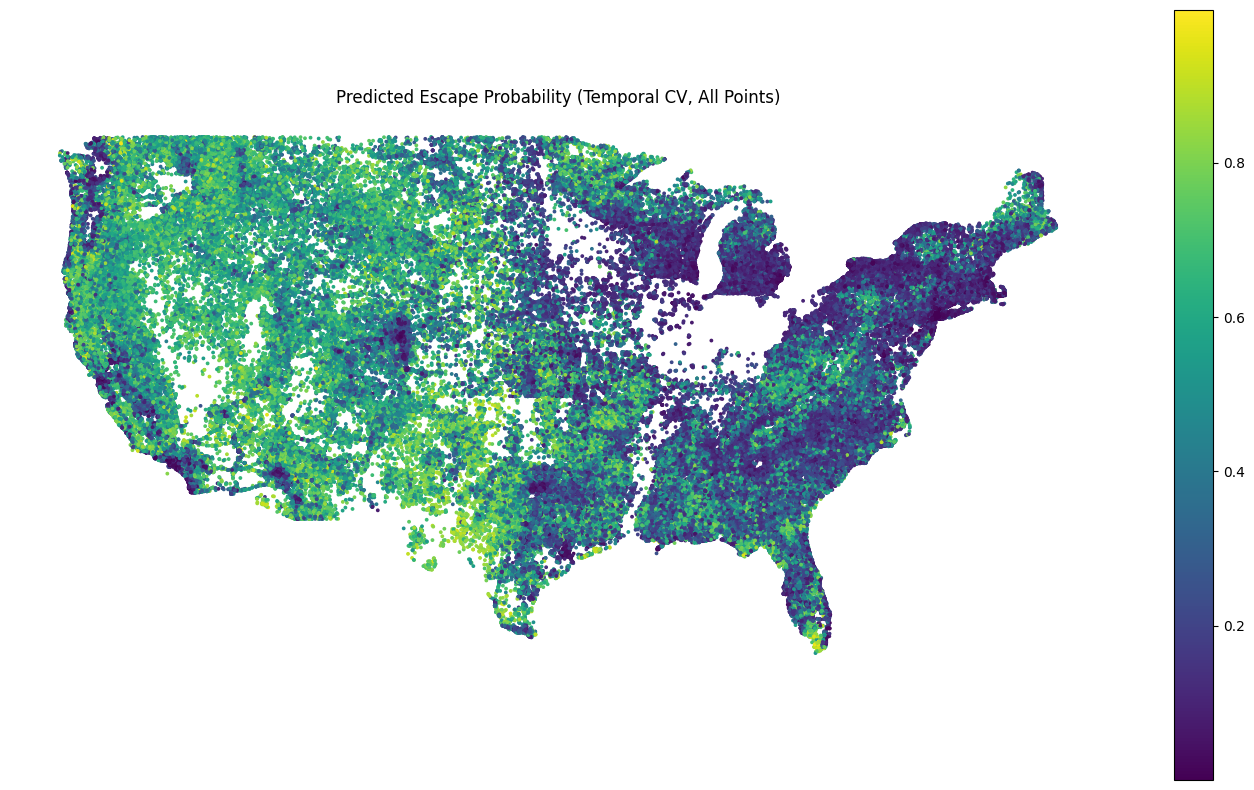

In [3]:
# === Year-Wise (Temporal) CV, Escape-Probability Mapping =====================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import geopandas as gpd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------#
# 0) PREP — cleaned DataFrame with LATITUDE, LONGITUDE, and DISCOVERY_DATE     #
# -----------------------------------------------------------------------------#
full_data = matched_clean.copy().reset_index(drop=True)
full_data['DISCOVERY_YEAR'] = pd.to_datetime(full_data['DISCOVERY_DATE']).dt.year

hazard_vars  = ['vpd_Normal','bi_Normal','fm100_Normal','srad_Normal','sph_Normal',
                'Slope','TRI','TPI','Elevation','erc','vs','Aridity_index','SDI']
values_vars  = ['Popo_1km','GHM','RPL_THEMES','EPL_MUNIT']
capacity_vars= ['NPL','GACC_PL','new_large_fires','type_2_teams','type_1_teams',
                'nimos','initial_attack_activity','engines','helicopters','crews']
predictors   = hazard_vars + values_vars + capacity_vars

X_all = full_data[predictors].values
y_all = full_data['event_type'].values

oof_probs = np.zeros(len(full_data))

# -----------------------------------------------------------------------------#
# 1) MODEL FACTORY                                                            #
# -----------------------------------------------------------------------------#
def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# -----------------------------------------------------------------------------#
# 2) TEMPORAL CV: train on all years < Y, test on year == Y                    #
# -----------------------------------------------------------------------------#
unique_years = sorted(full_data['DISCOVERY_YEAR'].unique())

for fold, year in enumerate(unique_years, start=1):
    train_mask = full_data['DISCOVERY_YEAR'] != year
    test_mask  = full_data['DISCOVERY_YEAR'] == year
    if test_mask.sum() == 0 or train_mask.sum() == 0:
        continue  # skip if year has no data or nothing before it

    X_train_raw, X_test_raw = X_all[train_mask], X_all[test_mask]
    y_train                 = y_all[train_mask]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_test  = scaler.transform(X_test_raw)

    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    cw = dict(enumerate(cw))

    model = build_model(X_train.shape[1])

    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)
    ]

    model.fit(X_train, y_train,
              epochs=2,
              batch_size=512,
              validation_split=0.2,
              class_weight=cw,
              verbose=0,
              callbacks=callbacks)

    oof_probs[test_mask] = model.predict(X_test, verbose=0).flatten()
    tf.keras.backend.clear_session()
    print(f"Fold {fold}: trained < {year}, tested == {year}, n_test={test_mask.sum()}")

# -----------------------------------------------------------------------------#
# 3) BUILD GEODATAFRAME WITH PREDICTIONS                                       #
# -----------------------------------------------------------------------------#
full_data['escape_prob'] = oof_probs
gdf = gpd.GeoDataFrame(
    full_data,
    geometry=gpd.points_from_xy(full_data['LONGITUDE'], full_data['LATITUDE']),
    crs='EPSG:4326'
)

# -----------------------------------------------------------------------------#
# 4) QUICK PLOT (add your own states layer if desired)                         #
# -----------------------------------------------------------------------------#
fig, ax = plt.subplots(figsize=(14, 8))
gdf.plot(ax=ax, column='escape_prob', cmap='viridis', markersize=3, legend=True)
ax.set_title('Predicted Escape Probability (Temporal CV, All Points)')
ax.set_axis_off()
plt.tight_layout()
plt.show()


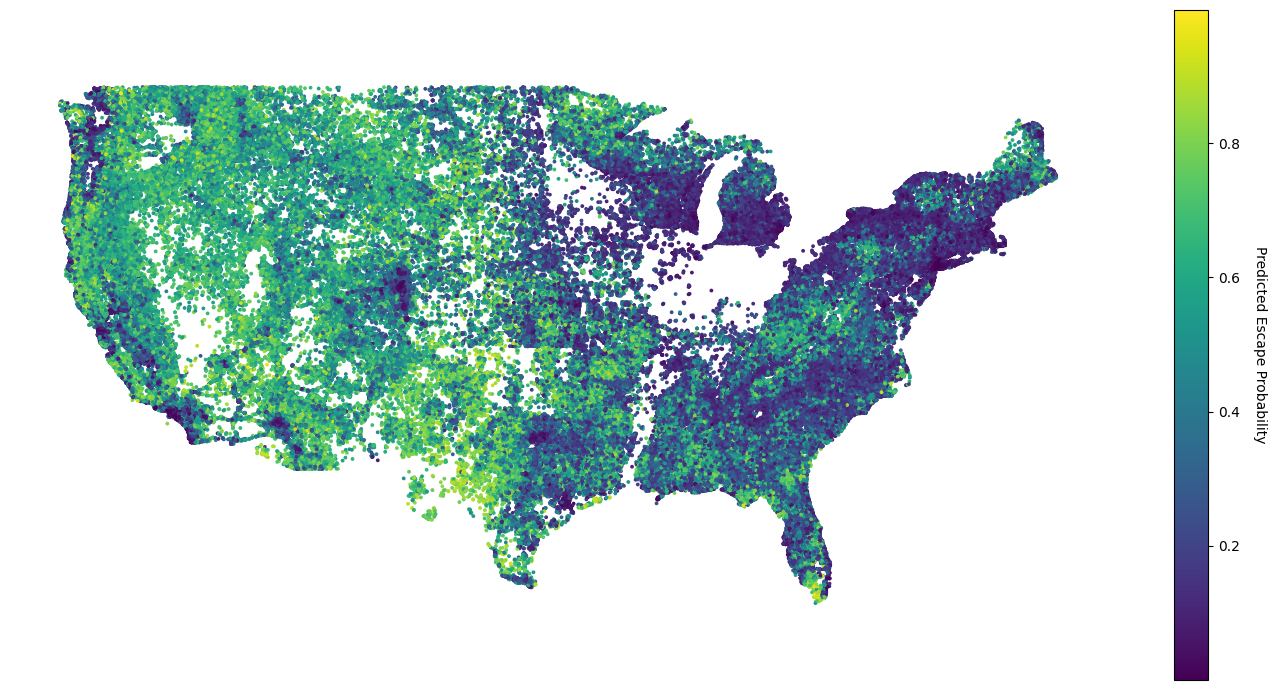

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 7))
# Plot and capture the colorbar
gdf_plot = gdf.plot(ax=ax, column='escape_prob', cmap='viridis', markersize=3, legend=True)
#ax.set_title('Predicted Escape Probability (Temporal CV, All Points)')
ax.set_axis_off()

# Access the colorbar and add rotated label
cbar = gdf_plot.get_figure().get_axes()[1]
cbar.set_ylabel("Predicted Escape Probability", rotation=270, labelpad=20)

plt.tight_layout()
#plt.savefig(r"C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\escape_probability_map.png", dpi=300, bbox_inches='tight')

plt.show()


In [13]:
predictors

['vpd_Normal',
 'bi_Normal',
 'fm100_Normal',
 'srad_Normal',
 'sph_Normal',
 'Slope',
 'TRI',
 'TPI',
 'Elevation',
 'erc',
 'vs',
 'Aridity_index',
 'SDI',
 'Popo_1km',
 'GHM',
 'RPL_THEMES',
 'EPL_MUNIT',
 'NPL',
 'GACC_PL',
 'new_large_fires',
 'type_2_teams',
 'type_1_teams',
 'nimos',
 'initial_attack_activity',
 'engines',
 'helicopters',
 'crews']

In [8]:
import pandas as pd, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# ─── DATA ──────────────────────────────────────────────────────────────────────
matched_clean = matched_clean.copy()
X = matched_clean[predictors]
y = matched_clean['event_type'].reset_index(drop=True)

# ─── TRAIN / TEST SPLIT ────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# ─── SCALING ───────────────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ─── CLASS WEIGHTS ─────────────────────────────────────────────────────────────
classes = np.unique(y_train)
cw = dict(zip(classes, compute_class_weight(class_weight='balanced', classes=classes, y=y_train)))

# ─── SIMPLE ONE‑LAYER NN ──────────────────────────────────────────────────────
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# ─── TRAIN ─────────────────────────────────────────────────────────────────────
model.fit(
    X_train_scaled, y_train,
    epochs=2,
    batch_size=512,
    validation_split=0.2,
    class_weight=cw,
    callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# ─── EVALUATION ───────────────────────────────────────────────────────────────
proba = model.predict(X_test_scaled, verbose=0).flatten()
auc  = roc_auc_score(y_test, proba)

best_t, best_f = max(
    ((t, f1_score(y_test, proba > t)) for t in np.linspace(0.01, 0.99, 99)),
    key=lambda x: x[1]
)
pred = proba > best_t
precision = precision_score(y_test, pred)
recall    = recall_score(y_test, pred)

print(f"AUC: {auc:.3f}")
print(f"Best threshold: {best_t:.2f}")
print(f"F1: {best_f:.3f}  Precision: {precision:.3f}  Recall: {recall:.3f}")


Epoch 1/2
487/487 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - auc: 0.7535 - loss: 0.5835 - val_auc: 0.8066 - val_loss: 0.5190
Epoch 2/2
487/487 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - auc: 0.8117 - loss: 0.5240 - val_auc: 0.8153 - val_loss: 0.5522
AUC: 0.809
Best threshold: 0.77
F1: 0.160  Precision: 0.120  Recall: 0.243


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  1%|▊                                                                                 | 1/100 [00:01<02:45,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  2%|█▋                                                                                | 2/100 [00:03<02:39,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|██▍                                                                               | 3/100 [00:04<02:40,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  4%|███▎                                                                              | 4/100 [00:06<02:38,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  5%|████                                                                              | 5/100 [00:08<02:37,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  6%|████▉                                                                             | 6/100 [00:09<02:35,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  7%|█████▋                                                                            | 7/100 [00:11<02:23,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  8%|██████▌                                                                           | 8/100 [00:12<02:15,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  9%|███████▍                                                                          | 9/100 [00:13<02:09,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 10%|████████                                                                         | 10/100 [00:15<02:13,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 11%|████████▉                                                                        | 11/100 [00:16<02:07,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 12%|█████████▋                                                                       | 12/100 [00:18<02:11,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 13%|██████████▌                                                                      | 13/100 [00:20<02:14,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 14%|███████████▎                                                                     | 14/100 [00:21<02:06,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 15%|████████████▏                                                                    | 15/100 [00:23<02:11,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 16%|████████████▉                                                                    | 16/100 [00:24<02:02,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 17%|█████████████▊                                                                   | 17/100 [00:25<01:58,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 18%|██████████████▌                                                                  | 18/100 [00:27<01:55,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 19%|███████████████▍                                                                 | 19/100 [00:28<01:52,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 20%|████████████████▏                                                                | 20/100 [00:30<01:57,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 21%|█████████████████                                                                | 21/100 [00:31<01:52,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 22%|█████████████████▊                                                               | 22/100 [00:32<01:47,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 23%|██████████████████▋                                                              | 23/100 [00:34<01:45,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 24%|███████████████████▍                                                             | 24/100 [00:35<01:42,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 25%|████████████████████▎                                                            | 25/100 [00:36<01:40,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 26%|█████████████████████                                                            | 26/100 [00:38<01:39,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 27%|█████████████████████▊                                                           | 27/100 [00:39<01:37,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 28%|██████████████████████▋                                                          | 28/100 [00:40<01:37,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 29%|███████████████████████▍                                                         | 29/100 [00:41<01:34,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 30%|████████████████████████▎                                                        | 30/100 [00:43<01:40,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 31%|█████████████████████████                                                        | 31/100 [00:44<01:36,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 32%|█████████████████████████▉                                                       | 32/100 [00:46<01:40,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 33%|██████████████████████████▋                                                      | 33/100 [00:48<01:38,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 34%|███████████████████████████▌                                                     | 34/100 [00:49<01:38,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 35%|████████████████████████████▎                                                    | 35/100 [00:51<01:41,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 36%|█████████████████████████████▏                                                   | 36/100 [00:53<01:42,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 37%|█████████████████████████████▉                                                   | 37/100 [00:54<01:43,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 38%|██████████████████████████████▊                                                  | 38/100 [00:56<01:36,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 39%|███████████████████████████████▌                                                 | 39/100 [00:57<01:36,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 40%|████████████████████████████████▍                                                | 40/100 [00:59<01:29,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 41%|█████████████████████████████████▏                                               | 41/100 [01:00<01:25,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 42%|██████████████████████████████████                                               | 42/100 [01:01<01:21,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 43%|██████████████████████████████████▊                                              | 43/100 [01:03<01:18,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 44%|███████████████████████████████████▋                                             | 44/100 [01:04<01:23,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 45%|████████████████████████████████████▍                                            | 45/100 [01:06<01:25,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 46%|█████████████████████████████████████▎                                           | 46/100 [01:07<01:19,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 47%|██████████████████████████████████████                                           | 47/100 [01:09<01:20,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 48%|██████████████████████████████████████▉                                          | 48/100 [01:10<01:16,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 49%|███████████████████████████████████████▋                                         | 49/100 [01:12<01:18,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 50%|████████████████████████████████████████▌                                        | 50/100 [01:13<01:14,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 51%|█████████████████████████████████████████▎                                       | 51/100 [01:15<01:15,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 52%|██████████████████████████████████████████                                       | 52/100 [01:16<01:10,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 53%|██████████████████████████████████████████▉                                      | 53/100 [01:18<01:05,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 54%|███████████████████████████████████████████▋                                     | 54/100 [01:19<01:01,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 55%|████████████████████████████████████████████▌                                    | 55/100 [01:20<01:01,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:22<01:05,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:24<01:06,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:25<01:00,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:26<00:56,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 60%|████████████████████████████████████████████████▌                                | 60/100 [01:27<00:53,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:29<00:51,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:30<00:50,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 63%|███████████████████████████████████████████████████                              | 63/100 [01:31<00:49,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:32<00:45,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:34<00:48,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:35<00:45,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:37<00:43,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 68%|███████████████████████████████████████████████████████                          | 68/100 [01:38<00:41,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:39<00:39,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:40<00:38,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:42<00:37,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:43<00:35,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:44<00:34,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:45<00:32,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:47<00:34,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:49<00:35,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:50<00:31,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:51<00:29,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:53<00:30,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:54<00:27,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:55<00:25,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:57<00:25,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:58<00:25,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [02:00<00:22,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [02:01<00:20,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [02:02<00:18,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [02:04<00:18,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [02:05<00:16,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [02:07<00:15,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [02:08<00:15,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [02:09<00:12,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [02:11<00:10,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [02:12<00:09,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [02:13<00:07,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [02:15<00:06,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [02:16<00:05,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [02:18<00:04,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [02:19<00:02,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [02:20<00:01,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


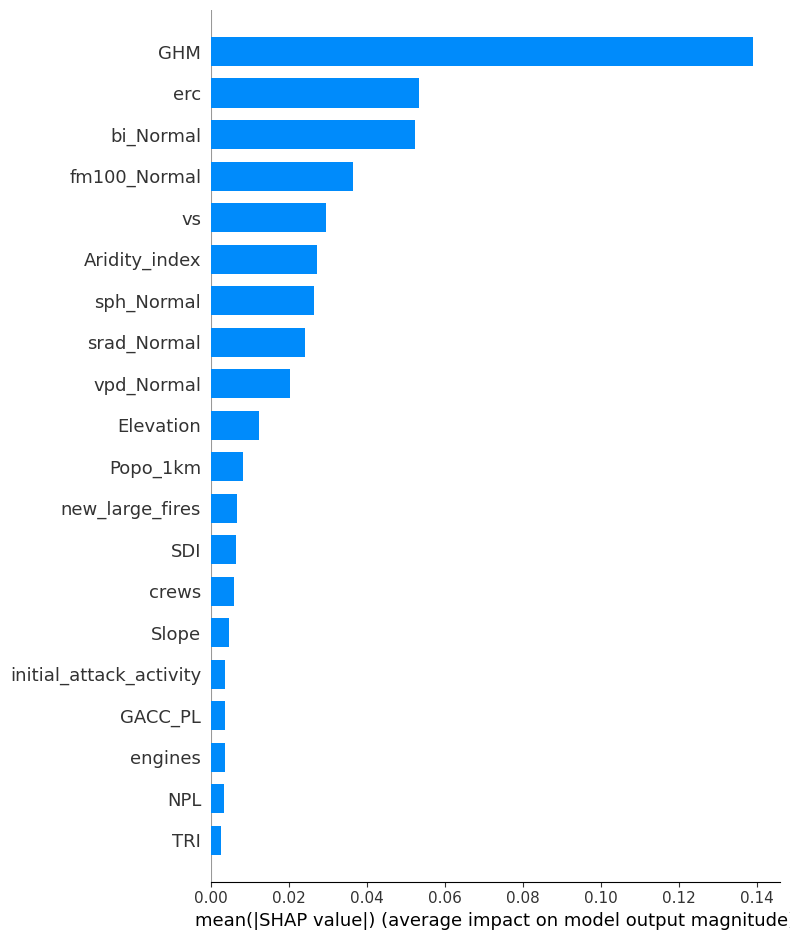

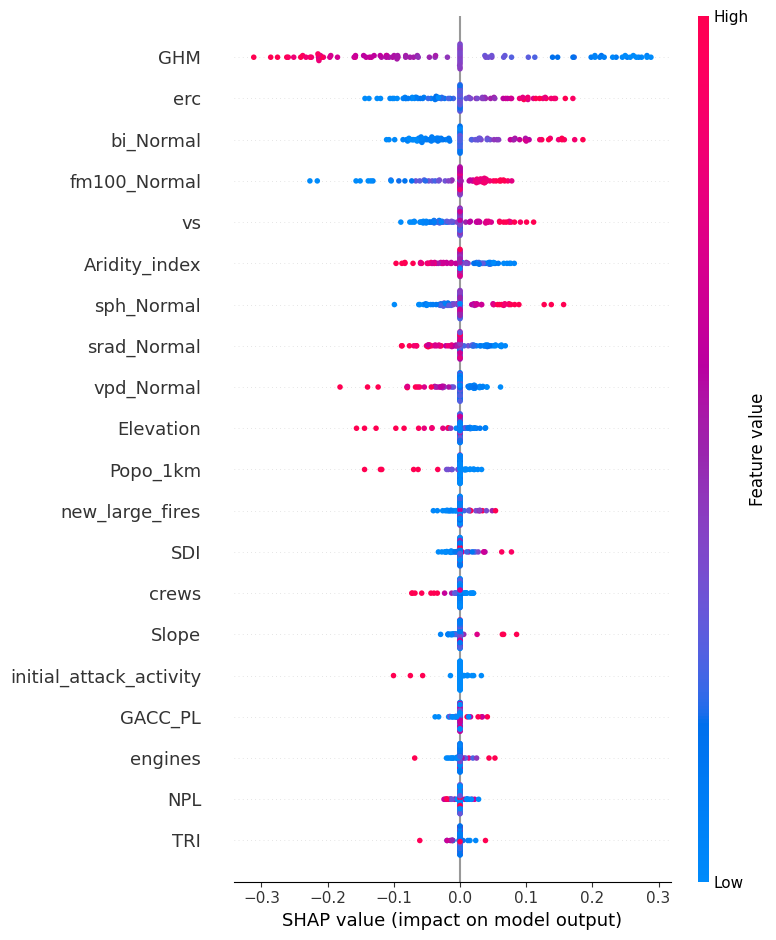

In [12]:
import shap, numpy as np, matplotlib.pyplot as plt

# Use a small background sample from training data
bg_sample = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]
test_sample = X_test_scaled[:100]  # Smaller batch for speed

# Wrap model prediction
def model_predict(X):
    return model.predict(X).flatten()

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, bg_sample)
shap_vals = explainer.shap_values(test_sample, nsamples=100)

# Convert to NumPy if needed
shap_vals = np.array(shap_vals)

max_feats = len(predictors)          # 27


# Plot feature importance
shap.summary_plot(shap_vals, test_sample, feature_names=X.columns, plot_type="bar", max_display=max_feats)
shap.summary_plot(shap_vals, test_sample, feature_names=X.columns,  max_display=max_feats)
